In [1]:

import tensorflow as tf
tf.__version__

'2.11.0'

In [2]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -U albumentations --no-binary qudida,albumentations


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import os

import cv2

import albumentations as albu
from albumentations import Compose, ShiftScaleRotate, Resize
from albumentations.pytorch import ToTensorV2


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

import shutil

import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

In [6]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3

In [7]:
os.listdir('DATA')

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [9]:
leaf_smut_list = \
os.listdir('DATA/Leaf smut')
brown_spot_list = \
os.listdir('DATA/Brown spot')
bacterial_leaf_blight_list = \
os.listdir('DATA/Bacterial leaf blight')

print(len(leaf_smut_list))
print(len(brown_spot_list))
print(len(bacterial_leaf_blight_list))

39
40
40


In [10]:

df_leaf_smut = pd.DataFrame(leaf_smut_list, columns=['image'])
df_leaf_smut['target'] = 'leaf_smut'

df_brown_spot = pd.DataFrame(brown_spot_list, columns=['image'])
df_brown_spot['target'] = 'brown_spot'

df_bacterial_leaf_blight = pd.DataFrame(bacterial_leaf_blight_list, columns=['image'])
df_bacterial_leaf_blight['target'] = 'bacterial_leaf_blight'
df_leaf_smut_val = df_leaf_smut.sample(n=5, random_state=101)
df_brown_spot_val = df_brown_spot.sample(n=5, random_state=101)
df_bacterial_leaf_blight_val = df_bacterial_leaf_blight.sample(n=5, random_state=101)


print(len(df_leaf_smut_val))
print(len(df_brown_spot_val))
print(len(df_bacterial_leaf_blight_val))

5
5
5


In [11]:
val_list = list(df_leaf_smut_val['image'])
df_leaf_smut_train = df_leaf_smut[~df_leaf_smut['image'].isin(val_list)] 
val_list = list(df_brown_spot_val['image'])
df_brown_spot_train = df_brown_spot[~df_brown_spot['image'].isin(val_list)] 
val_list = list(df_bacterial_leaf_blight_val['image'])
df_bacterial_leaf_blight_train = \
df_bacterial_leaf_blight[~df_bacterial_leaf_blight['image'].isin(val_list)]


print(len(df_leaf_smut_train))
print(len(df_brown_spot_train))
print(len(df_bacterial_leaf_blight_train))

34
35
35


In [12]:

df_data = pd.concat([df_leaf_smut, df_brown_spot, df_bacterial_leaf_blight], axis=0).reset_index(drop=True)

df_train = \
pd.concat([df_leaf_smut_train, df_brown_spot_train, df_bacterial_leaf_blight_train], axis=0).reset_index(drop=True)

df_val = \
pd.concat([df_leaf_smut_val, df_brown_spot_val, df_bacterial_leaf_blight_val], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)
df_train = shuffle(df_train)
df_val = shuffle(df_val)

print(df_data.shape)
print(df_train.shape)
print(df_val.shape)

(119, 2)
(104, 2)
(15, 2)


In [13]:
df_data['target'].value_counts()

brown_spot               40
bacterial_leaf_blight    40
leaf_smut                39
Name: target, dtype: int64

In [14]:
df_train['target'].value_counts()

bacterial_leaf_blight    35
brown_spot               35
leaf_smut                34
Name: target, dtype: int64

In [15]:
df_val['target'].value_counts()

bacterial_leaf_blight    5
leaf_smut                5
brown_spot               5
Name: target, dtype: int64

In [16]:
val_len = len(df_val)
train_len = len(df_train)
df_combined =  pd.concat(objs=[df_val, df_train], axis=0).reset_index(drop=True)

df_combined = pd.get_dummies(df_combined, columns=['target'])

df_val = df_combined[:val_len]
df_train = df_combined[val_len:]

print(df_train.shape)
print(df_val.shape)




(104, 4)
(15, 4)


In [17]:
df_combined.head()


,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0396.JPG,1,0,0
1,DSC_0513.jpg,0,0,1
2,DSC_0303.JPG,0,1,0
3,DSC_0336.jpg,0,0,1
4,DSC_0501.jpg,0,0,1


In [18]:
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
15,DSC_0379.JPG,1,0,0
16,DSC_0110.jpg,0,1,0
17,DSC_0115.jpg,0,1,0
18,DSC_0370.jpg,1,0,0
19,DSC_0114.jpg,0,1,0


In [19]:
df_val.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0396.JPG,1,0,0
1,DSC_0513.jpg,0,0,1
2,DSC_0303.JPG,0,1,0
3,DSC_0336.jpg,0,0,1
4,DSC_0501.jpg,0,0,1


In [20]:
df_combined.to_csv('df_combined.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

In [21]:
image_dir = 'image_dir'
os.mkdir(image_dir)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'image_dir'

In [22]:
leaf_smut_list = \
os.listdir('DATA/Leaf smut')
brown_spot_list = \
os.listdir('DATA/Brown spot')
bacterial_leaf_blight_list = \
os.listdir('DATA/Bacterial leaf blight')

for fname in leaf_smut_list:
    
    path = 'DATA/Leaf smut/'

    src = os.path.join(path, fname)
    dst = os.path.join(image_dir, fname)
    shutil.copyfile(src, dst)
    
    
for fname in brown_spot_list:
    
    path = 'DATA/Brown spot/'
    
    src = os.path.join(path, fname)
    dst = os.path.join(image_dir, fname)
    shutil.copyfile(src, dst)
    
    
    
    

for fname in bacterial_leaf_blight_list:
    
    path = 'DATA/Bacterial leaf blight/'
    
    src = os.path.join(path, fname)
    dst = os.path.join(image_dir, fname)
    shutil.copyfile(src, dst)
       

In [23]:
len(os.listdir('image_dir'))

119

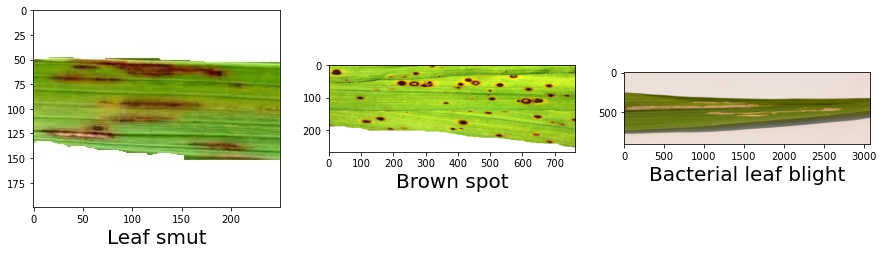

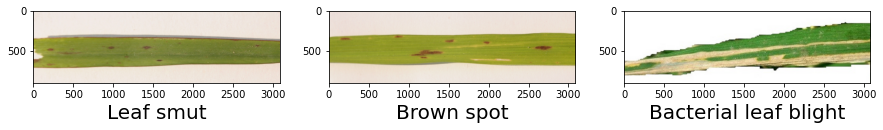

In [24]:
plt.figure(figsize=(15,15))

plt.subplot(1,3,1)   
item = 'DSC_0512.jpg'
path = 'DATA/Leaf smut/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)

plt.subplot(1,3,2)   
item = 'DSC_0108.jpg'
path = 'DATA/Brown spot/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)

plt.subplot(1,3,3)  
item = 'DSC_0402.JPG'
path = 'DATA/Bacterial leaf blight/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)






plt.figure(figsize=(15,15))

plt.subplot(1,3,1)  
item = 'DSC_0316.JPG'
path = 'DATA/Leaf smut/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)

plt.subplot(1,3,2)   
item = 'DSC_0303.JPG'
path = 'DATA/Brown spot/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)

plt.subplot(1,3,3)  
item = 'DSC_0702.jpg'
path = 'DATA/Bacterial leaf blight/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)

plt.show()


In [25]:

import albumentations as albu


def augment_image(augmentation, image):
    
    """
    Uses the Albumentations library.
    
    Inputs: 
    1. augmentation - this is the instance of type of augmentation to do 
    e.g. aug_type = HorizontalFlip(p=1) 
    # p=1 is the probability of the transform being executed.
    
    2. image - image with shape (h,w)
    
    Output:
    Augmented image as a numpy array.
    
    """
    aug_image_dict =  augmentation(image=image)
    image_matrix = aug_image_dict['image']
    
    
    return image_matrix

In [26]:

aug_types = albu.Compose([
            albu.HorizontalFlip(),
             albu.OneOf([
                albu.HorizontalFlip(),
                albu.VerticalFlip(),
                ], p=0.8),
            albu.OneOf([
                albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness(),
                ], p=0.3),
            albu.OneOf([
                albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                albu.GridDistortion(),
                albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                ], p=0.3),
            albu.ShiftScaleRotate()
            ])

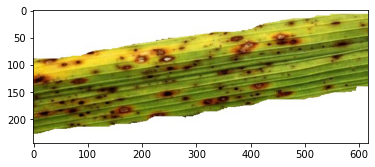

In [27]:
path = 'image_dir/'
image_list = os.listdir('image_dir')

fname = image_list[1]
image_path = path + fname

image = plt.imread(image_path)
plt.imshow(image)

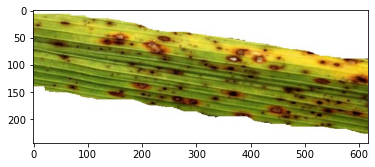

In [28]:
aug_image = augment_image(aug_types, image)

plt.imshow(aug_image)

In [29]:
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
15,DSC_0379.JPG,1,0,0
16,DSC_0110.jpg,0,1,0
17,DSC_0115.jpg,0,1,0
18,DSC_0370.jpg,1,0,0
19,DSC_0114.jpg,0,1,0


In [30]:
def train_generator(batch_size=8):
    
    while True:
        
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):
            
            image_id_list = list(df['image'])
            
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            for i in range(0, len(image_id_list)):
              
              
                image_id = image_id_list[i]

                path = 'image_dir/' + image_id

                image = cv2.imread(path)
                
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                
            
            
                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_train = df[cols]
                y_train = np.asarray(y_train) 

               
                aug_image = augment_image(aug_types, image)
              
                X_train[i] = aug_image
                
                          
                
            X_train = X_train/255

            yield X_train, y_train

In [31]:
train_gen = train_generator(batch_size=8)
X_train, y_train = next(train_gen)

print(X_train.shape)
print(y_train.shape)

(8, 224, 224, 3)
(8, 3)


In [32]:
y_train

array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]], dtype=int64)

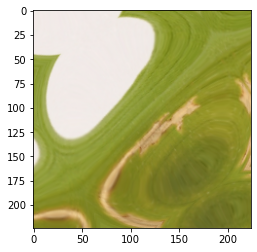

In [33]:
image = X_train[0,:,:,:]
plt.imshow(image)

In [34]:
def val_generator(batch_size=5):
    
    while True:
        
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            image_id_list = list(df['image'])
            
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
          
            for i in range(0, len(image_id_list)):
              
              
                image_id = image_id_list[i]


                path = 'image_dir/' + image_id

                image = cv2.imread(path)
                
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                X_val[i] = image
                
            

                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_val = df[cols]
                y_val = np.asarray(y_val) 

                     
            X_val = X_val/255

            yield X_val, y_val

In [35]:
val_gen = val_generator(batch_size=5)

X_val, y_val = next(val_gen)

print(X_val.shape)
print(y_val.shape)

(5, 224, 224, 3)
(5, 3)


In [36]:
y_val

array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]], dtype=int64)

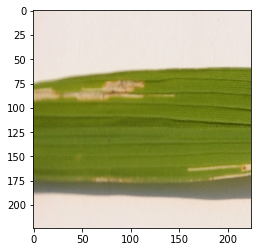

In [37]:
image = X_val[0,:,:,:]
plt.imshow(image)

In [38]:
def test_generator(batch_size=1):
    
    while True:
        
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            image_id_list = list(df['image'])
            
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            for i in range(0, len(image_id_list)):
              
              
                image_id = image_id_list[i]


                path = 'image_dir/' + image_id

                image = cv2.imread(path)
                
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                X_test[i] = image
                
                 
                
            X_test = X_test/255

            yield X_test

In [39]:
test_gen = test_generator(batch_size=1)

X_test = next(test_gen)

print(X_test.shape)

(1, 224, 224, 3)


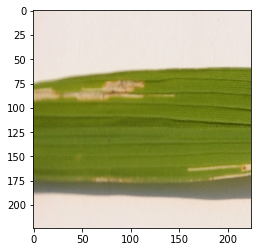

In [40]:
image = X_test[0,:,:,:]
plt.imshow(image)

In [41]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import categorical_accuracy

from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)

In [42]:
from tensorflow.keras.applications.mobilenet import MobileNet

model = MobileNet(weights='imagenet')

x = model.layers[-2].output

predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [43]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 5

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = TRAIN_BATCH_SIZE
val_batch_size = VAL_BATCH_SIZE



train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [44]:
train_gen = train_generator(batch_size=TRAIN_BATCH_SIZE)
val_gen = val_generator(batch_size=VAL_BATCH_SIZE)

model.compile(
    Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)



filepath = "model.h5"


checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   #verbose=1, mode='min')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, csv_logger]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=100, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)


Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 5.8543 - accuracy: 0.5096
Epoch 1: val_accuracy improved from -inf to 0.46667, saving model to model.h5
13/13 [==============================] - 23s 1s/step - loss: 5.8543 - accuracy: 0.5096 - val_loss: 18.5317 - val_accuracy: 0.4667
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 2.9896 - accuracy: 0.7788
Epoch 2: val_accuracy improved from 0.46667 to 0.66667, saving model to model.h5
13/13 [==============================] - 14s 1s/step - loss: 2.9896 - accuracy: 0.7788 - val_loss: 15.9069 - val_accuracy: 0.6667
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 3.2785 - accuracy: 0.7308
Epoch 3: val_accuracy did not improve from 0.66667
13/13 [==============================] - 14s 1s/step - loss: 3.2785 - accuracy: 0.7308 - val_loss: 15.7812 - val_accuracy: 0.6667
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 2.2955 - accuracy: 0.7692
Epoch 4: val_accurac

In [45]:


train_log = pd.read_csv('training_log.csv')

train_log.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.509615,5.854314,0.466667,18.531734
1,1,0.778846,2.989650,0.666667,15.906905
2,2,0.730769,3.278469,0.666667,15.781248
3,3,0.769231,2.295469,0.333333,18.846048
4,4,0.865385,2.204247,0.600000,3.936604


In [46]:
model.metrics_names

['loss', 'accuracy']

In [47]:
model.load_weights('model.h5')

val_gen = val_generator(batch_size=1)

val_loss, val_acc = \
model.evaluate_generator(val_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.0722719207406044
val_acc: 1.0


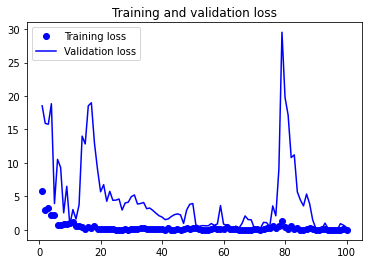

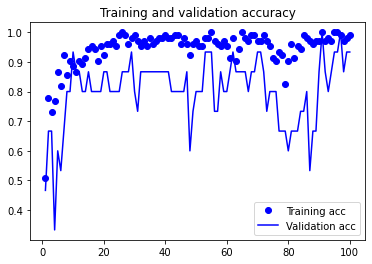

<Figure size 432x288 with 0 Axes>

In [48]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()

In [49]:
test_gen = test_generator(batch_size=1)

preds = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

15/15 [==============================] - 1s 44ms/step


In [50]:
y_pred = np.argmax(preds, axis=1)

y_pred

array([0, 2, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 1, 1, 0], dtype=int64)

In [51]:
cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
y_true = df_val[cols]
y_true = np.asarray(y_true) 

y_true = np.argmax(y_true, axis=1)

y_true

array([0, 2, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 1, 1, 0], dtype=int64)

In [52]:

print(y_pred)
print(y_true)

[0 2 1 2 2 2 1 0 0 0 1 2 1 1 0]
[0 2 1 2 2 2 1 0 0 0 1 2 1 1 0]


In [53]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
[[5 0 0]
 [0 5 0]
 [0 0 5]]


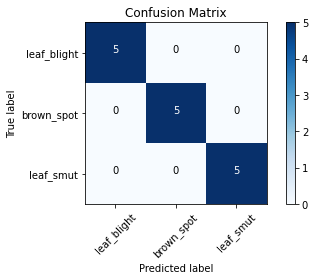

In [54]:

cm_plot_labels = ['leaf_blight', 'brown_spot', 'leaf_smut']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [55]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=['bacterial_leaf_blight', 'brown_spot', 'leaf_smut'])

print(report)

                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      1.00      1.00         5
           brown_spot       1.00      1.00      1.00         5
            leaf_smut       1.00      1.00      1.00         5

             accuracy                           1.00        15
            macro avg       1.00      1.00      1.00        15
         weighted avg       1.00      1.00      1.00        15

